In [1]:
%run functions.ipynb
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
labels = load_file('data/labels_for_microarray_data.csv')
dataset = pd.read_csv('data/microarray_data.csv', delimiter=",", index_col=0).T
print(labels.shape, dataset.shape)
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print("(1, 0) labels count in train test: {} {}".format((np.count_nonzero(y_train==1), np.count_nonzero(y_train==0)), 
                                                        (np.count_nonzero(y_test==1), np.count_nonzero(y_test==0))))

(969,) (969, 12179)
Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


In [3]:
n_iter = 30
cv = 4
n_jobs = 4
scoring = 'roc_auc'

# Basic classifier on raw data

In [4]:
logistic_params = {'C' : np.linspace(0.01, 1, 50), 'penalty' : ['l1'], 'solver' : ['liblinear']}

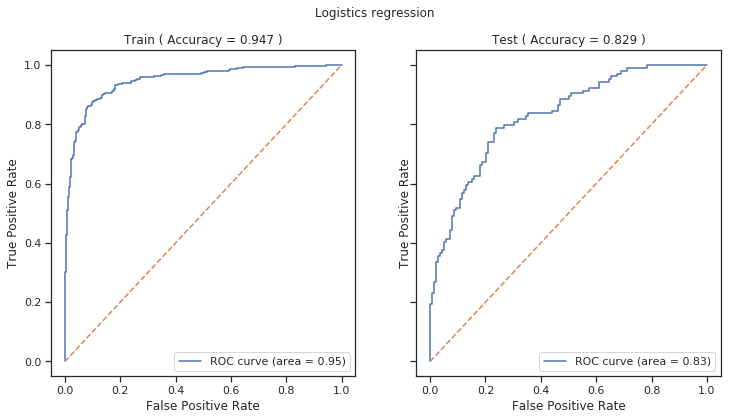

In [5]:
logit_cv = RandomizedSearchCV(LogisticRegression(random_state=random_state), cv=cv, scoring=scoring, n_iter=n_iter, n_jobs=n_jobs, iid=False, param_distributions=logistic_params) 
clf_logit = fit_clf(logit_cv, X_train, y_train, X_test, y_test, "Logistics regression")

# Other scores

In [6]:
clf_logit, train_scores, test_scores = clf_scores(clf_logit, X_train, y_train, X_test, y_test)
print_scores(train_scores, test_scores)

,ROC AUC,Precision,Recall,F1
train,0.947,0.883,0.810,0.845
test,0.829,0.720,0.692,0.706


# Data statistics

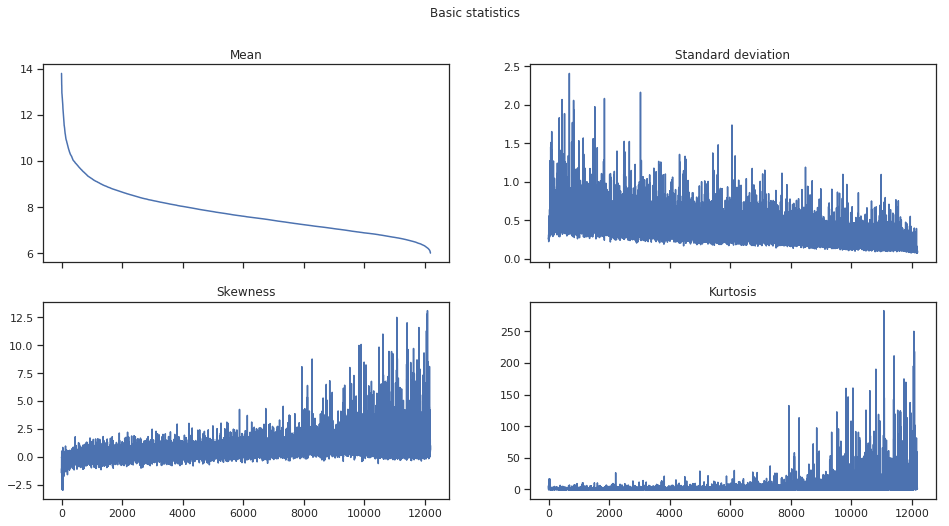

In [7]:
from scipy.stats import skew, kurtosis

def compute_basic_statistics(dataset):
    p = dataset.shape[1]
    means = np.mean(dataset, axis=0)
    stds = np.std(dataset, axis=0)
    skews = skew(dataset, axis=0)
    kurtoses = kurtosis(dataset, axis=0)

    fig, axes = plt.subplots(nrows = 2, ncols=2, figsize = (16,8), sharex=True)
    fig.suptitle("Basic statistics")
    (ax1, ax2, ax3, ax4) = np.array(axes).flatten()
    ax1.plot(np.arange(p), means)
    ax1.set_title("Mean")
    ax2.plot(np.arange(p), stds)
    ax2.set_title("Standard deviation")
    ax3.plot(np.arange(p), skews)
    ax3.set_title("Skewness")
    ax4.plot(np.arange(p), kurtoses)
    ax4.set_title("Kurtosis")
    plt.show()
    
    return p, means, stds, skews, kurtoses

p, means, stds, skews, kurtoses = compute_basic_statistics(dataset)

In [8]:
print('Means, min: {:.2f}, max: {:.2f}'.format(np.min(means), np.max(means)))
print('Stds, min: {:.2f}, max: {:.2f}'.format(np.min(stds), np.max(stds)))
print('Skews, min: {:.2f}, max: {:.2f}'.format(np.min(skews), np.max(skews)))
print('Kurtoses, min: {:.2f}, max: {:.2f}'.format(np.min(kurtoses), np.max(kurtoses)))

Means, min: 6.01, max: 13.79
Stds, min: 0.07, max: 2.41
Skews, min: -2.99, max: 13.10
Kurtoses, min: -1.38, max: 282.88


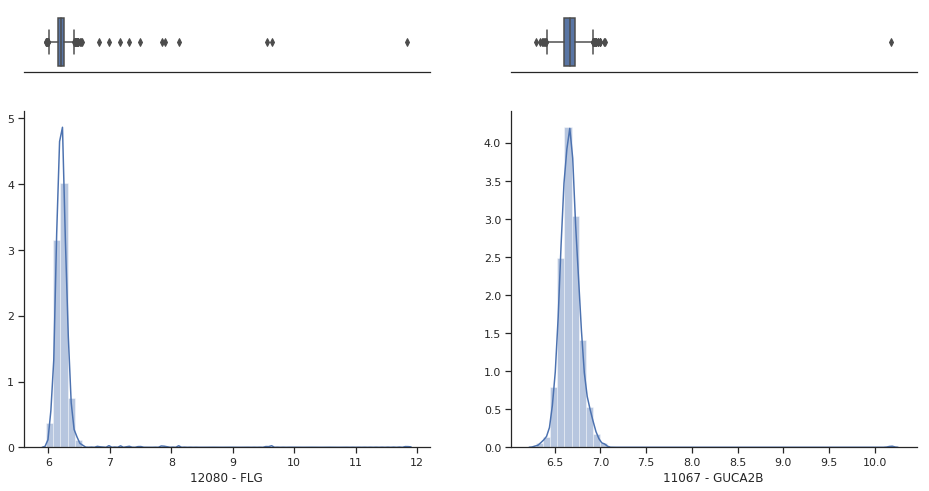

In [9]:
skewness_max_index = np.argmax(skews)
kurtosis_max_index = np.argmax(kurtoses)

fig, axes = plt.subplots(nrows = 2, ncols=2, figsize = (16,8), gridspec_kw={"height_ratios": (.15, .85)})
(ax_box1, ax_box2, ax_hist1, ax_hist2) = np.array(axes).flatten()
boxplot_hist(dataset, skewness_max_index, ax_box1, ax_hist1)
boxplot_hist(dataset, kurtosis_max_index, ax_box2, ax_hist2)
plt.show()

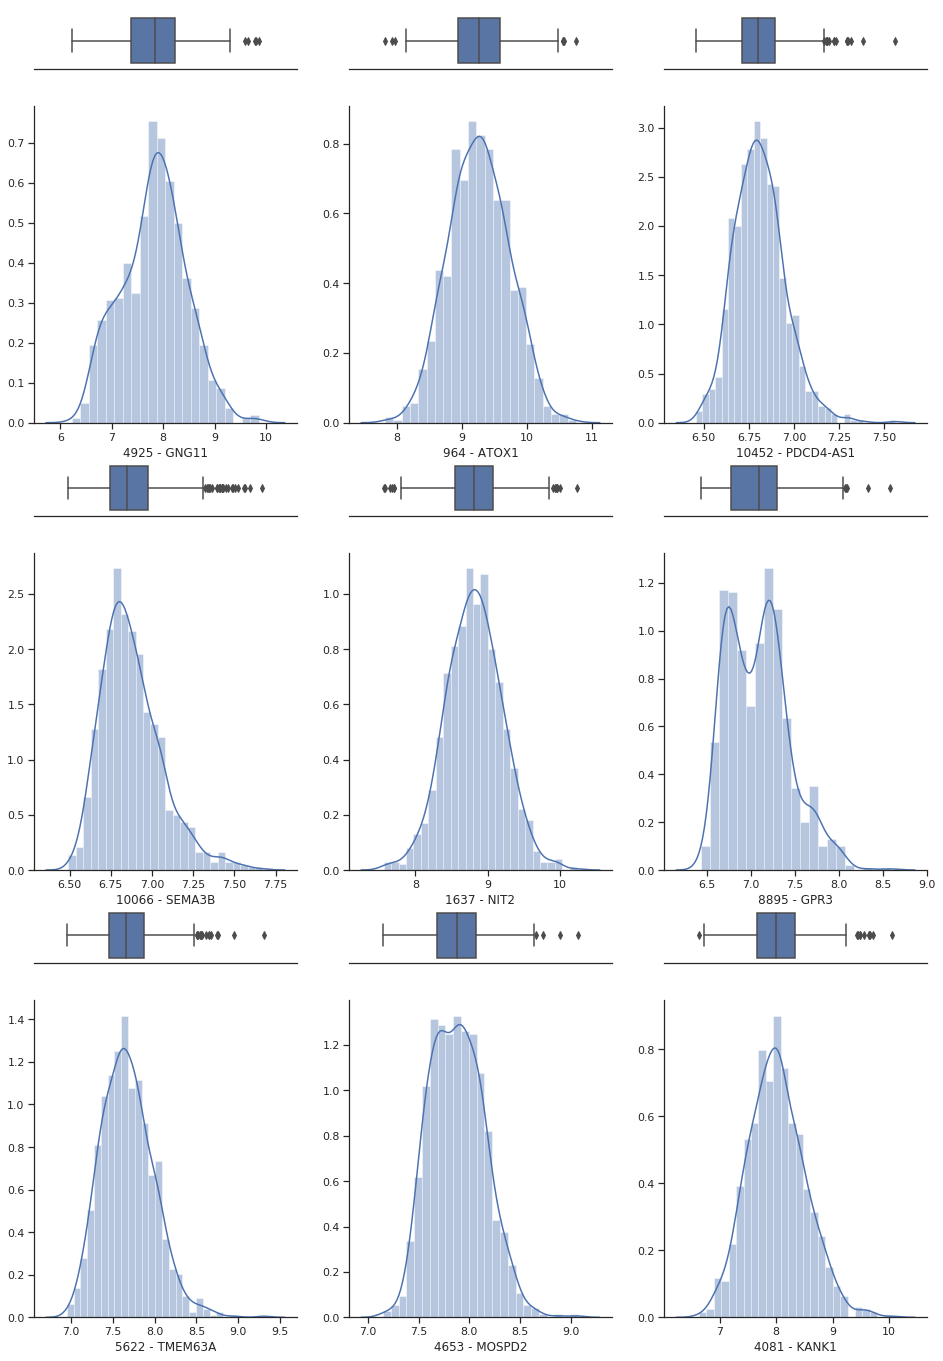

In [10]:
rows = 3
cols = 3
random_indices = np.random.choice(dataset.shape[1], rows*cols, replace=False)
fig, axes = plt.subplots(nrows = 2*rows, ncols = cols, figsize=(16,24), 
                         gridspec_kw={"height_ratios": (.15, .85, .15, .85, .15, .85)})

for j in range(rows):
    for i in range(cols):
        column_idx = random_indices[rows*j+i]
        ax_box = axes[2*j][i]
        ax_hist = axes[2*j+1][i]
        boxplot_hist(dataset, column_idx, ax_box, ax_hist)
plt.show()

Checks connected with skewness and kurtosis:

* how many variables have skew, kurtosis above certain threshold - it appears that not many, in fact the variable indices for this staistics are almost the same - it may be therefore valid to try to get rid of these variables at all
* how many patients have values of one of the genes in this outlying region exceeding 99%-quantile for this value - unfortunately, it turns out that almost all

In [11]:
kurt_quant = np.quantile(kurtoses, [0.95, 0.99])
skew_quant = np.quantile(skews, [0.95, 0.99])
print("Skewness quatiles: q_95 = {:.2f}, q_99 = {:.2f}".format(*skew_quant))
print("Kurtosis quatiles: q_95 = {:.2f}, q_99 = {:.2f}".format(*kurt_quant))

quant = {0.95: 0, 0.99: 1}
threshold_skew = skew_quant[quant[0.95]]
threshold_kurt = kurt_quant[quant[0.95]]
nonnormal_indices = [
    x for x in np.arange(p) if kurtoses[x] > threshold_kurt or skews[x] > threshold_skew
]
indices_skew = [x for x in np.arange(p) if skews[x] > threshold_skew]
indices_kurt = [x for x in np.arange(p) if kurtoses[x] > threshold_kurt]

print("Number of genes with outlying skewness or kutosis: {}".format(len(nonnormal_indices)))
print("Number of genes with outlying skewness : {}".format(len(indices_skew)))
print("Number of genes with outlying kurtosis : {}".format(len(indices_kurt)))

quantiles = [np.quantile(dataset.iloc[:, j], 0.99) for j in nonnormal_indices]

patients_indices = []
for i in np.arange(dataset.shape[0]):
    for idx, j in enumerate(nonnormal_indices):
        if dataset.iloc[i, j] > quantiles[idx]:
            patients_indices += [i]

patients_indices = np.unique(patients_indices)
print(
    "Number of patients with at least one extreme value of some outlying gene: {}".format(
        len(patients_indices)
    )
)

Skewness quatiles: q_95 = 2.15, q_99 = 4.93
Kurtosis quatiles: q_95 = 9.77, q_99 = 46.43
Number of genes with outlying skewness or kutosis: 710
Number of genes with outlying skewness : 609
Number of genes with outlying kurtosis : 609
Number of patients with at least one extreme value of some outlying gene: 907


In [12]:
random_indices = np.random.choice(np.arange(p), size = 50, replace=False)
correlation = dataset.iloc[:, random_indices].corr()

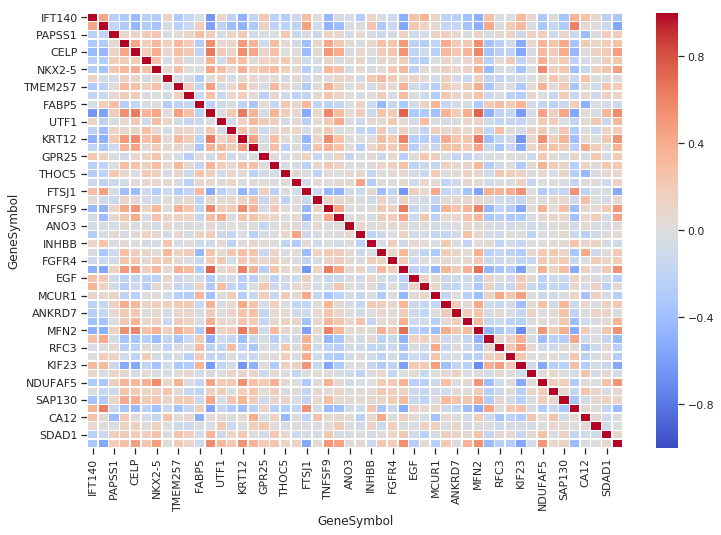

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(correlation, vmin=-1, vmax=1, center=0, cmap='coolwarm', linewidth=0.5)
plt.show()

# Comparison of how models behave when discarding outlying variables:

* on all the rest of the varibales it is a little worse
* when we consder only these outlying variables we get significantly worse results
* when we consider 2 random subsets of variables of the same size as number of discarded variables we get results a little bit worse than in the first case and a little better than in the second case

In [14]:
dataset_95 = dataset.iloc[:, [x for x in np.arange(p) if x not in nonnormal_indices]]
dataset_05 = dataset.iloc[:, [x for x in np.arange(p) if x in nonnormal_indices]]

Train and test sizes: (726, 11469) (243, 11469)
(1, 0) labels count in train test: (289, 437) (104, 139)


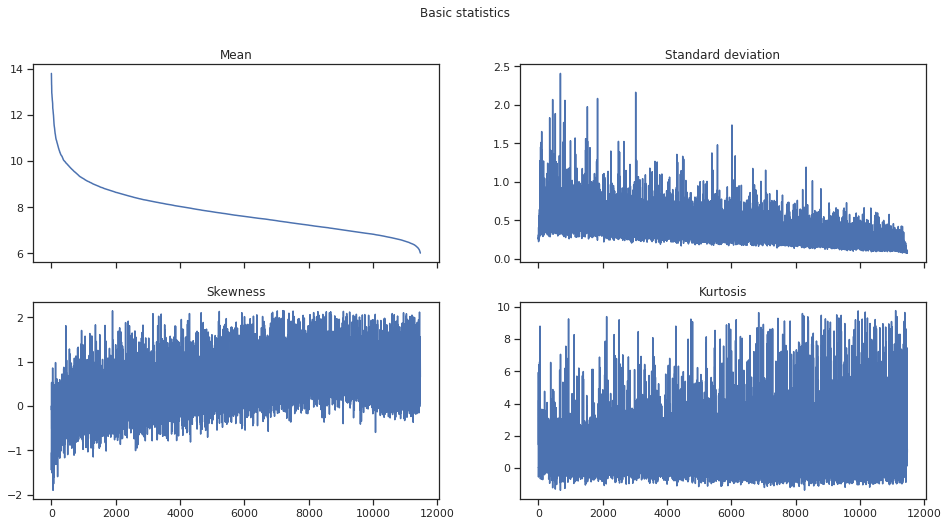

LogisticRegression(C=0.15142857142857144, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


,ROC AUC,Precision,Recall,F1
train,0.945,0.883,0.813,0.847
test,0.827,0.718,0.712,0.715


In [15]:
def basic_insight(dataset):
    X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.25, random_state=random_state)
    print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
    print("(1, 0) labels count in train test: {} {}".format((np.count_nonzero(y_train==1), np.count_nonzero(y_train==0)), 
                                                            (np.count_nonzero(y_test==1), np.count_nonzero(y_test==0))))
    
    p, means, stds, skews, curtoses = compute_basic_statistics(dataset)
    logit_cv = RandomizedSearchCV(LogisticRegression(random_state=random_state), cv=cv, scoring=scoring, n_iter=n_iter, n_jobs=n_jobs, iid=False, param_distributions=logistic_params) 
    clf_logit = fit_clf_print_scores(logit_cv, X_train, y_train, X_test, y_test)
    
basic_insight(dataset_95)

Train and test sizes: (726, 710) (243, 710)
(1, 0) labels count in train test: (289, 437) (104, 139)


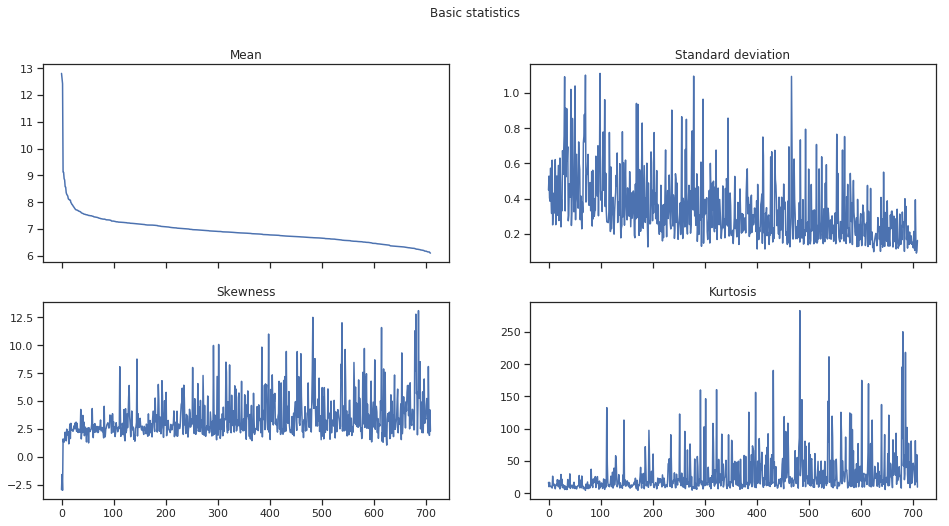

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


,ROC AUC,Precision,Recall,F1
train,0.989,0.967,0.917,0.941
test,0.742,0.659,0.577,0.615


In [16]:
basic_insight(dataset_05)

In [18]:
train_scores_all = []
test_scores_all = []
n = 50
for i in range(n):
    dataset_random = dataset.iloc[:, np.random.choice(np.arange(p), size = dataset_05.shape[1], replace=False)]
    X_train, X_test, y_train, y_test = train_test_split(dataset_random, labels, test_size=0.25, random_state=random_state)
    logit_cv = RandomizedSearchCV(LogisticRegression(), cv=cv, scoring=scoring, n_iter=n_iter, n_jobs=n_jobs, iid=False, param_distributions=logistic_params) 
    clf_logit, train_scores, test_scores = fit_clf_scores(logit_cv, X_train, y_train, X_test, y_test)
    train_scores_all += [train_scores]
    test_scores_all += [test_scores]

In [19]:
mean_train_score = Scores()
mean_test_score = Scores()
for i in range(n):
    mean_train_score += train_scores_all[i]
    mean_test_score += test_scores_all[i]
mean_train_score /= n
mean_test_score /= n

print_scores(mean_train_score, mean_test_score)

,ROC AUC,Precision,Recall,F1
train,0.915,0.847,0.758,0.800
test,0.787,0.700,0.616,0.655
